We are provided with a large set of retina images taken using fundus photography under a variety of imaging conditions. A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

We are asked to build a machine learning model to speed up disease detection. There are thousands of images collected in rural areas to help identify diabetic retinopathy automatically.

Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two ratings.


## Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import warnings
warnings.filterwarnings("ignore")

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so 

['sample_submission.csv', 'train.csv', 'test.csv', 'train_images', 'test_images']


Using TensorFlow backend.


## Load data

In [2]:
# load train and test.csv
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
# How does the train file look like?
train.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

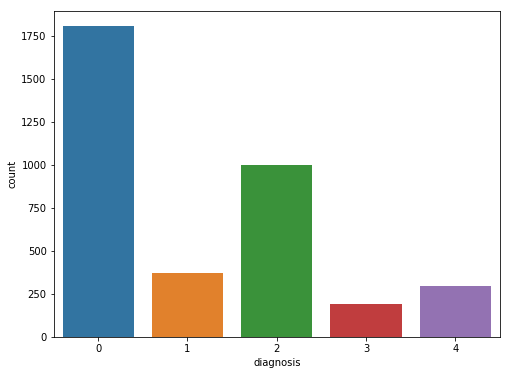

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.countplot(train['diagnosis'], ax=ax)

Almost half of the training data (1805 / 3662) has the score of 0. So this is a unbalanced dataset.

In [5]:
# How does the test file look like?
test.head()

id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4

In [6]:
# train images
train_image_list = os.listdir("../input/train_images")
print("{} train images".format(len(train_image_list)))
print(train_image_list[:10])

3662 train images
['6630f8675a97.png', '7fe7309d0b4f.png', '4d21ce39c905.png', '150fc7127582.png', 'b842b43cb7fb.png', 'a2d349f567a6.png', 'dc3c0d8ee20b.png', '16ce555748d8.png', 'c561bcd519e9.png', '3c28fd846b43.png']


In [7]:
# test images
test_image_list = os.listdir("../input/test_images")
print("{} test images".format(len(test_image_list)))
print(test_image_list[:10])

1928 test images
['78ce997489a4.png', 'b22d649a343a.png', 'a67503dd5c37.png', 'f3daf369a103.png', '8fb196f59171.png', '1388399910c7.png', 'fe0a340c4477.png', 'cb484b214c95.png', 'b4f238551dfe.png', 'fcd166e6e4b5.png']


# Visualization
## Score: 0

There are 1805 / 3662 images with the score of 0.


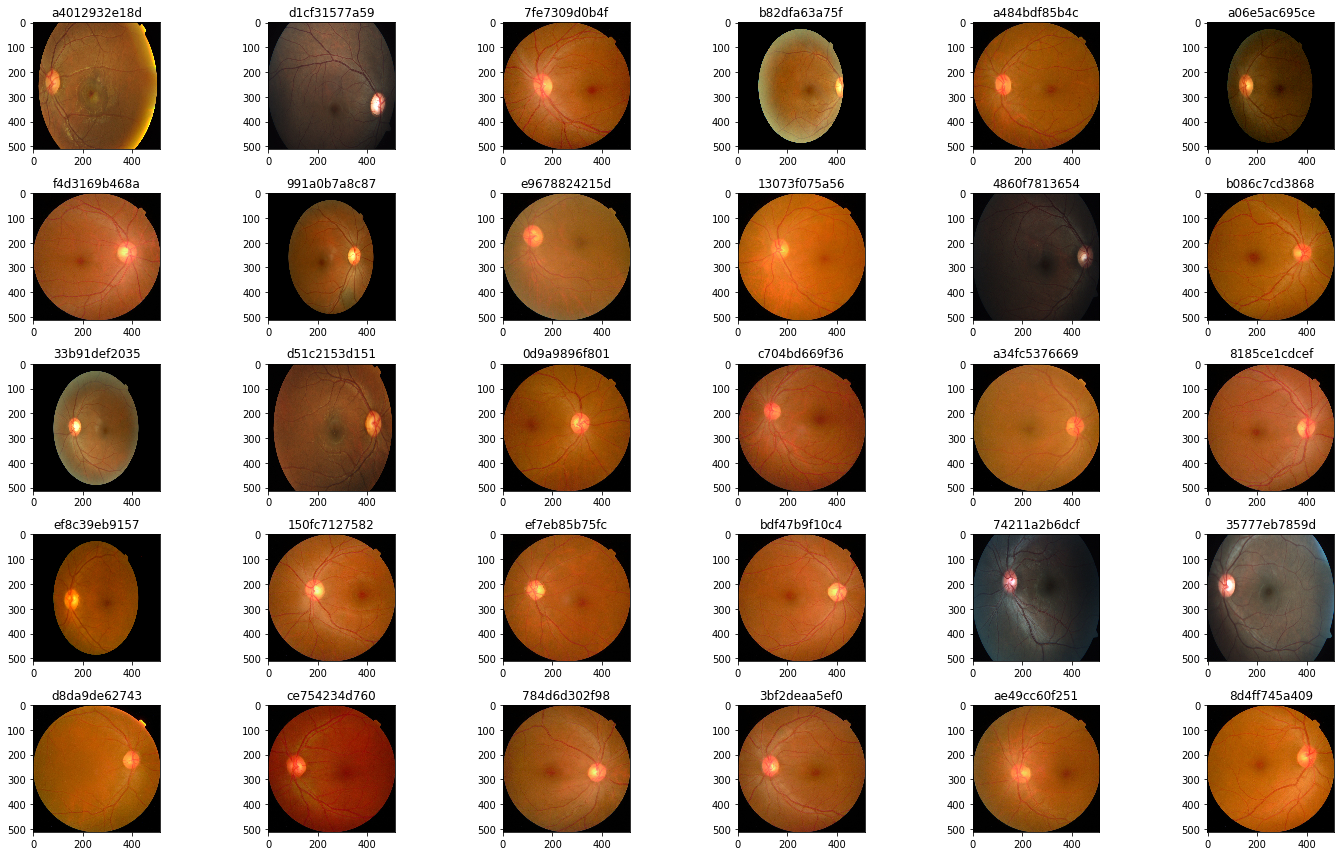

In [8]:
# visualize random N images whose score is 0 (No DR)
def visualize_images(train, s, N):
    # select image with the score of s
    train_image_list = train.loc[train['diagnosis'] == s, 'id_code'].tolist()    
    print("There are {} / 3662 images with the score of {}.".format(len(train_image_list), s))

    # random N choices of images
    np.random.seed(42)
    random_choice = np.random.choice(len(train_image_list), N)
    
    # visualize
    nrow = int(np.floor(np.sqrt(N)))
    fig, ax = plt.subplots(nrow, int(N/nrow), figsize=(20, 12))
    ax = ax.flatten()
    for n in range(N):
        img = cv2.imread('../input/train_images/' + train_image_list[random_choice[n]] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR to RGB
        img = cv2.resize(img, (512, 512)) # resize to 512 x 512 (for now)
        ax[n].imshow(img)
        ax[n].set_title(train_image_list[random_choice[n]])    
    plt.tight_layout()
    
# examples of images (score = 0) 
visualize_images(train, 0, 30)

They are healthy guys. Again, almost half of the training data (1805 / 3662) has the score of 0.

## Score: 1

There are 370 / 3662 images with the score of 1.


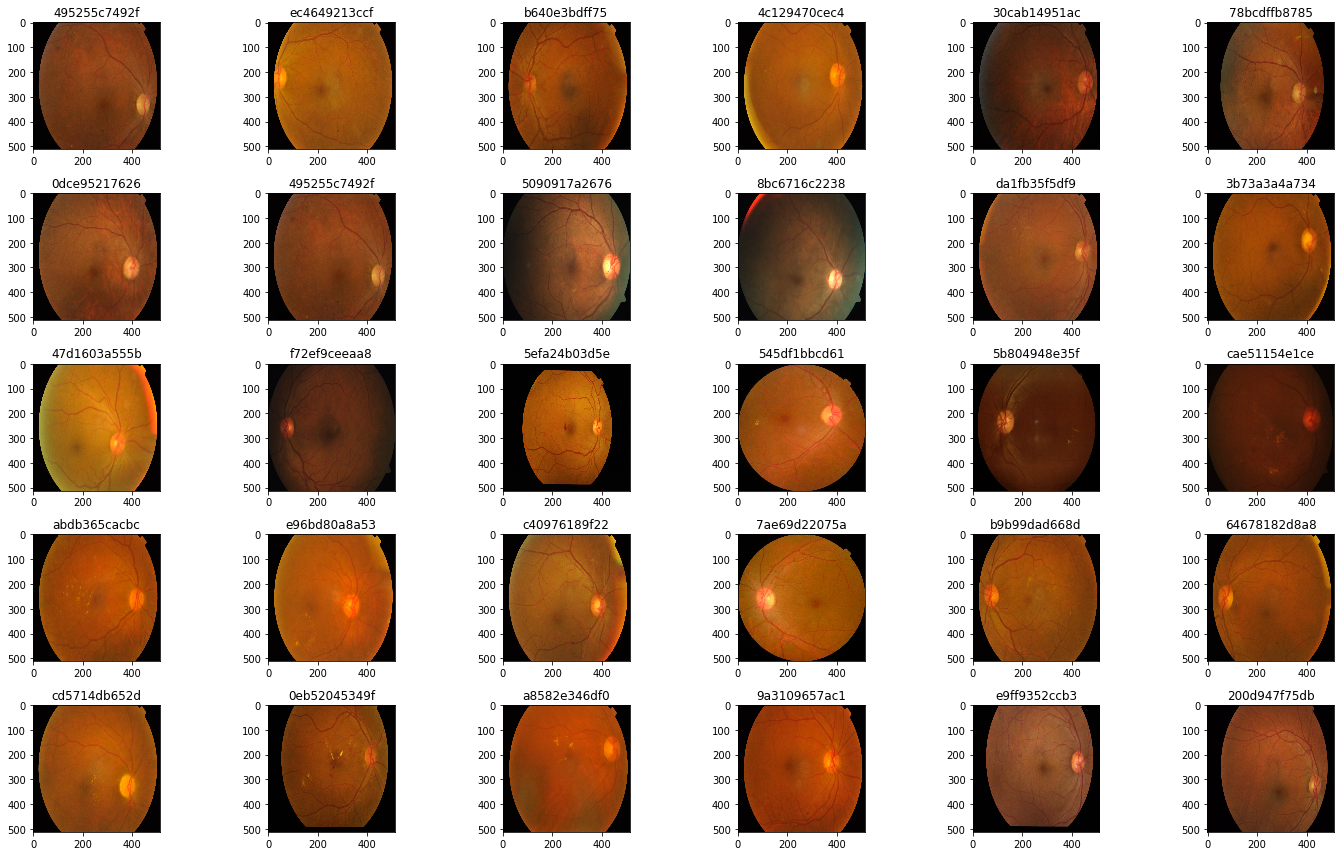

In [9]:
# visualize random N images whose score is 1 (mild)
visualize_images(train, 1, 30)

I am not a medical professional, so I don't see the difference between score 0 and 1;(

## Score: 2

There are 999 / 3662 images with the score of 2.


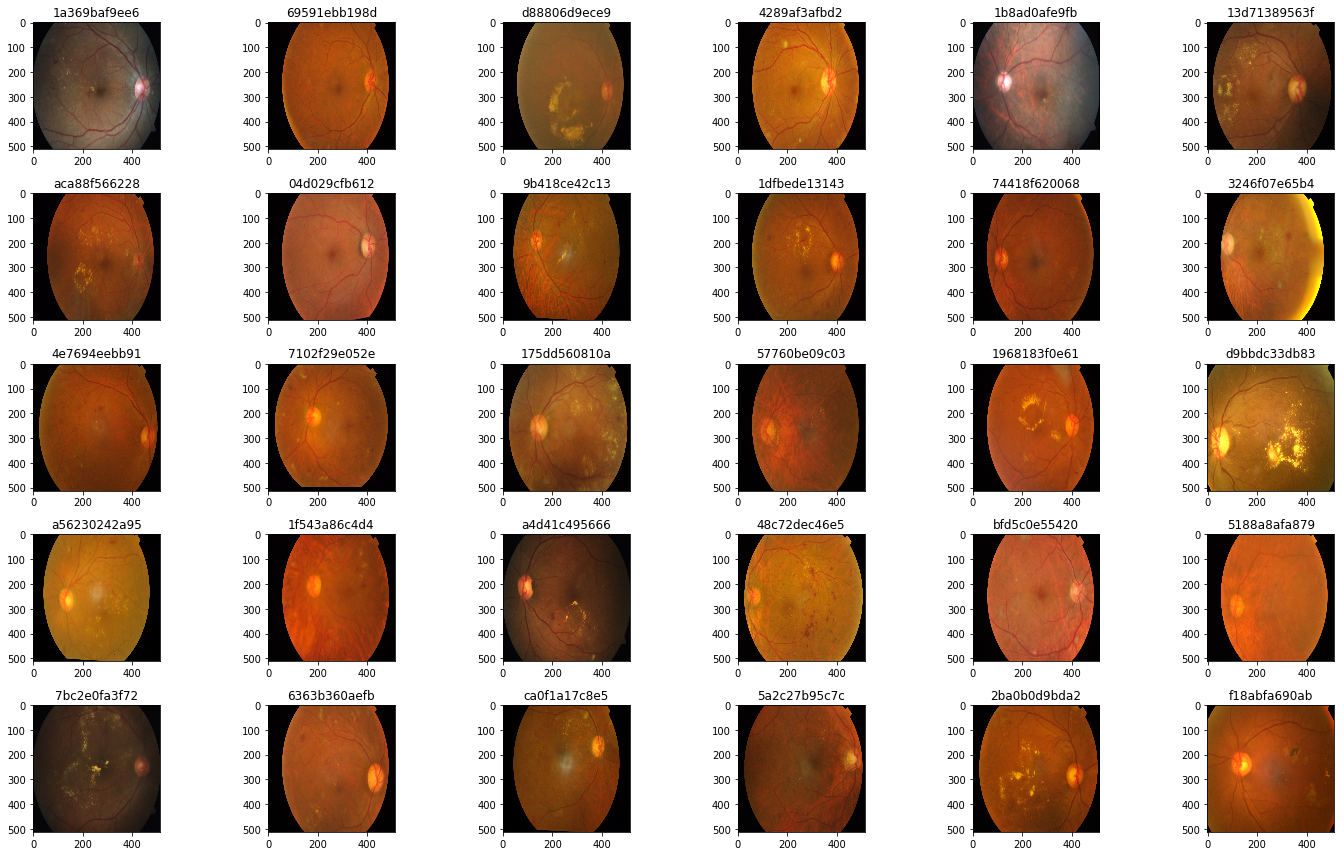

In [10]:
# visualize random N images whose score is 1 (mild)
visualize_images(train, 2, 30)

OK, maybe it is just a variability of the quality of the images but they do not always look similar in spite of the same score.

## Score: 3

There are 193 / 3662 images with the score of 3.


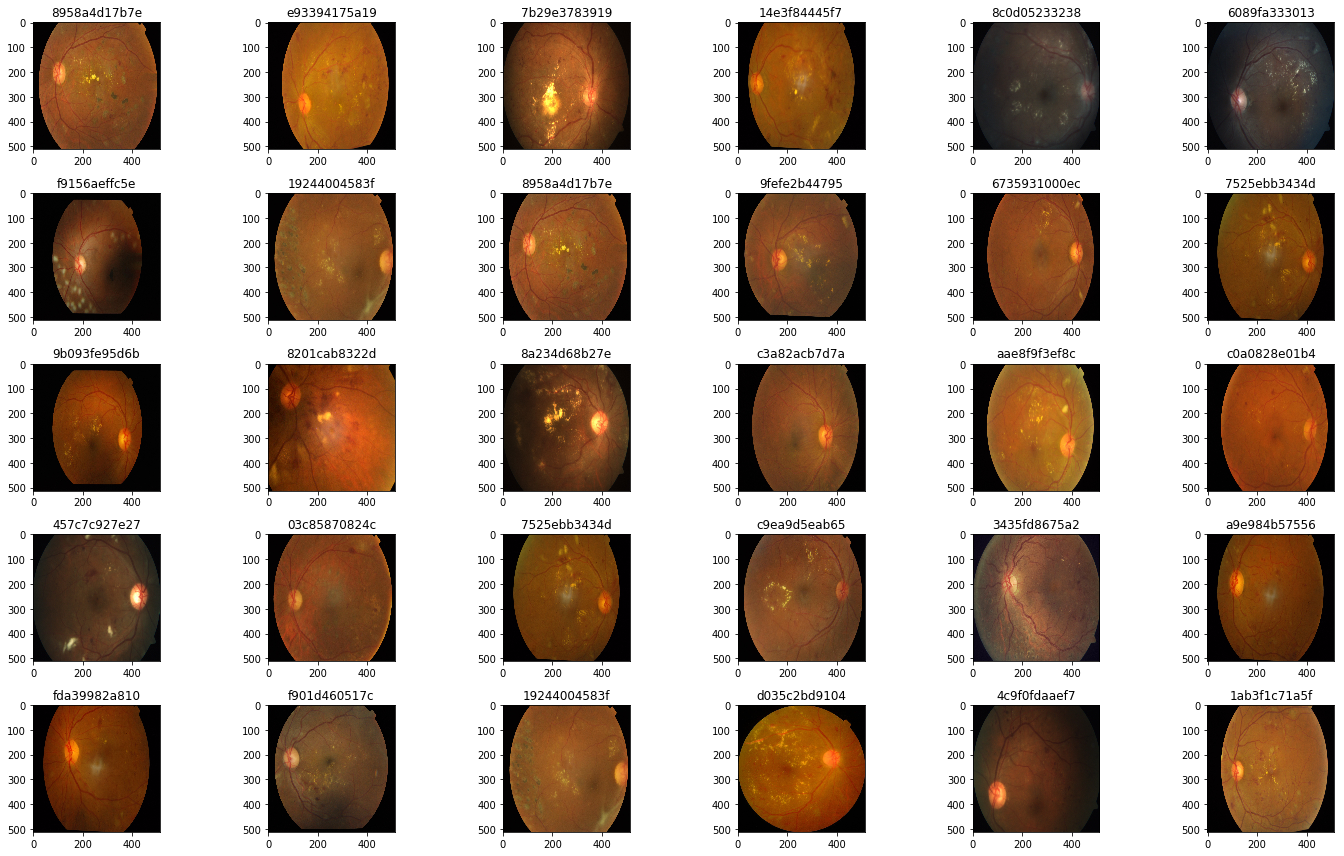

In [11]:
# visualize random N images whose score is 1 (mild)
visualize_images(train, 3, 30)

## Score: 4

There are 295 / 3662 images with the score of 4.


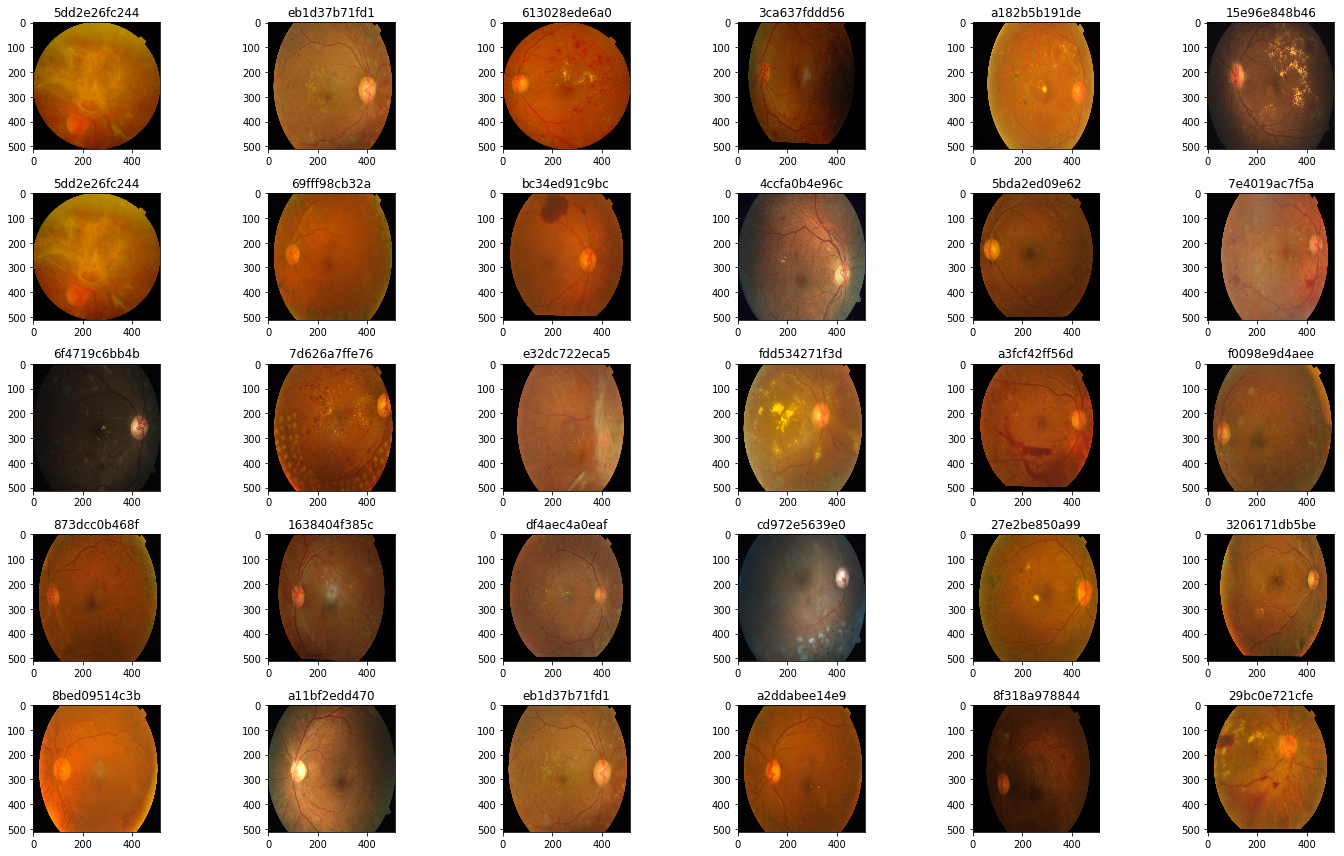

In [12]:
# visualize random N images whose score is 4 (Proliferative DR)
visualize_images(train, 4, 30)

Ah...some of them may look indeed not healthy...

# Organize matrix

In [13]:
# train image data
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((train.shape[0], npix, npix))
for i in range(train.shape[0]):
    # load an image
    img = cv2.imread('../input/train_images/' + train.loc[i, 'id_code'] + '.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train)))   

X_train shape: (3662, 224, 224)


In [14]:
# test image data
X_test = np.zeros((test.shape[0], npix, npix))
for i in range(test.shape[0]):
    # load an image
    img = cv2.imread('../input/test_images/' + test.loc[i, 'id_code'] + '.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_test[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_test shape: " + str(np.shape(X_test))) 

X_test shape: (1928, 224, 224)


# Check blurriness of images
As these seems to be a variety of the quality of images, it may be worthwhile computing **laplacian variance** to quantify the blur.

Text(0.5, 1.0, 'blurriness')

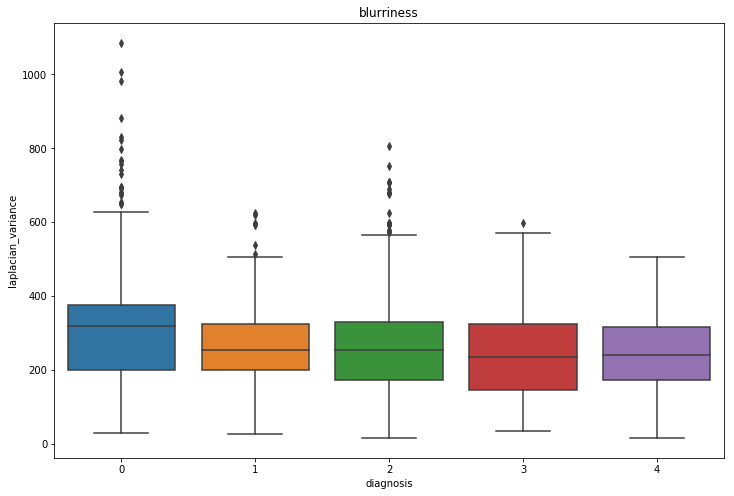

In [15]:
def laplacian_variance(images):
    return [cv2.Laplacian(image, cv2.CV_32F).var() for image in images]

laplacian_variances = laplacian_variance(X_train.astype('uint8'))
# print(len(laplacian_variances))
# print(len(train['diagnosis']))
blur_df = pd.DataFrame({'diagnosis': train['diagnosis'], 'laplacian_variance': laplacian_variances})

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.boxplot(x='diagnosis', y='laplacian_variance', data=blur_df, ax=ax)
ax.set_title('blurriness')

The quality of images vary a lot within the same class, but fortunately it is not systematically different across diagnosis.

# PCA

Before modeling, let's check if we can find clusters of the data in a PCA subspace.

Text(0.5, 1.0, 'PCA')

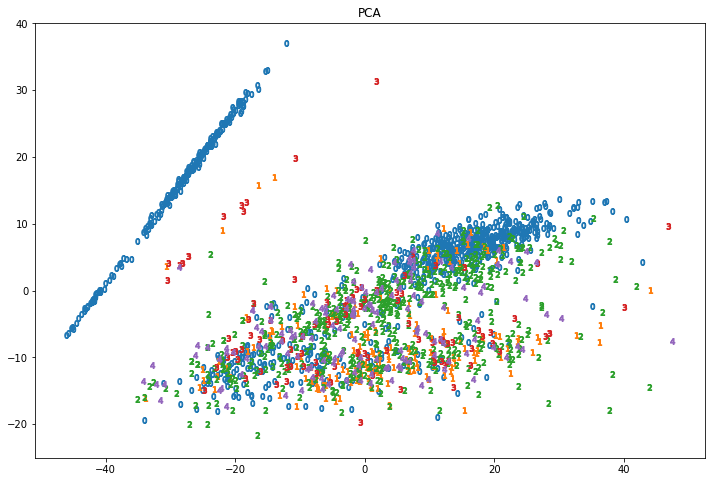

In [16]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)

# use a subset of the data
trainX, valX, trainy, valy = train_test_split(X, train['diagnosis'], test_size=0.5, random_state=1220)

X_decomposed = PCA(n_components=2).fit_transform(trainX)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cmap = get_cmap("tab10")

for i in range(5):
    marker = "$" + str(i) + "$"
    idx = trainy == i
    ax.scatter(X_decomposed[idx, 0], X_decomposed[idx, 1],
              marker=marker, color=cmap(i))
ax.set_title("PCA")

# TSNE

How about t-SNE?

Text(0.5, 1.0, 't-SNE')

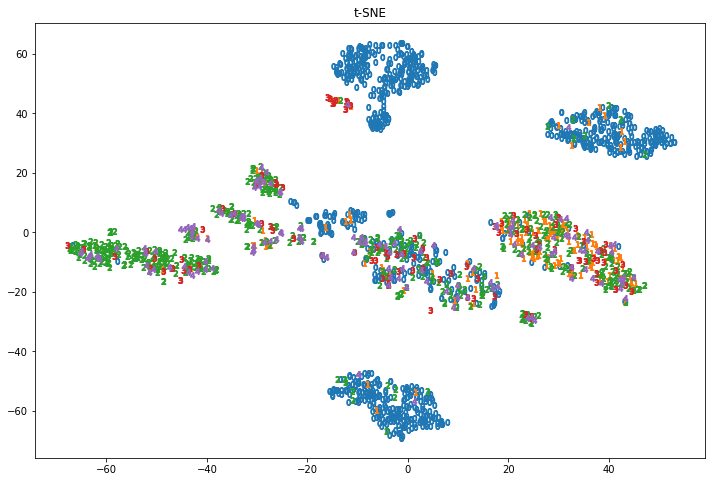

In [17]:
X_decomposed = TSNE(n_components=2).fit_transform(trainX)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for i in range(5):
    marker = "$" + str(i) + "$"
    idx = trainy == i
    ax.scatter(X_decomposed[idx, 0], X_decomposed[idx, 1],
              marker=marker, color=cmap(i))
ax.set_title("t-SNE")

Good news and bad news. Good news is that we can find distinct clusters separating 0 from others. Bad news is that telling a difference between 1 - 4 is very hard.

# VAE

Highly inspired by ["Visualizing MNIST using a Variational Autoencoder" by Rebecca Vislay Wade](https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder).

In [18]:
# hyperparameters
epochs = 10
batch_size = 200
latent_dim = 2 # dimensionality of the latent space

# encoder
input_img = keras.Input(shape=(npix, npix, 1))
x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

In [19]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [20]:
# decoder
decoder_input = layers.Input(K.int_shape(z)[1:])

# expand to npix x npix pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3, padding='same', 
                           activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# declare decoder
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [21]:
# loss
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        
        return K.mean(xent_loss + kl_loss)
    
    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [22]:
# VAE compile
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [23]:
# train VAE
trainX = np.reshape(trainX, (-1, npix, npix, 1))
valX = np.reshape(valX, (-1, npix, npix, 1))
# print(np.shape(valX))
# print(np.shape(trainX))
vae.fit(x=trainX, y=None, 
        shuffle=True, epochs=epochs,
        batch_size=batch_size, 
        validation_data=(valX, None))

Train on 1831 samples, validate on 1831 samples
Epoch 1/10
1831/1831 [==============================] - 14s 8ms/step - loss: 7645434771.7239 - val_loss: 0.6563
Epoch 2/10
1831/1831 [==============================] - 9s 5ms/step - loss: 0.6409 - val_loss: 0.6190
Epoch 3/10
1831/1831 [==============================] - 9s 5ms/step - loss: 0.5883 - val_loss: 0.5605
Epoch 4/10
1831/1831 [==============================] - 9s 5ms/step - loss: 0.5492 - val_loss: 0.5374
Epoch 5/10
1831/1831 [==============================] - 9s 5ms/step - loss: 0.5321 - val_loss: 0.5290
Epoch 6/10
1831/1831 [==============================] - 9s 5ms/step - loss: 0.5300 - val_loss: 0.5314
Epoch 7/10
1831/1831 [==============================] - 9s 5ms/step - loss: 0.5220 - val_loss: 0.5219
Epoch 8/10
1831/1831 [==============================] - 9s 5ms/step - loss: 0.5215 - val_loss: 0.5176
Epoch 9/10
1831/1831 [==============================] - 9s 5ms/step - loss: 0.5184 - val_loss: 0.5160
Epoch 10/10
1831/1831 [=

Text(0.5, 1.0, "VAE's latent space")

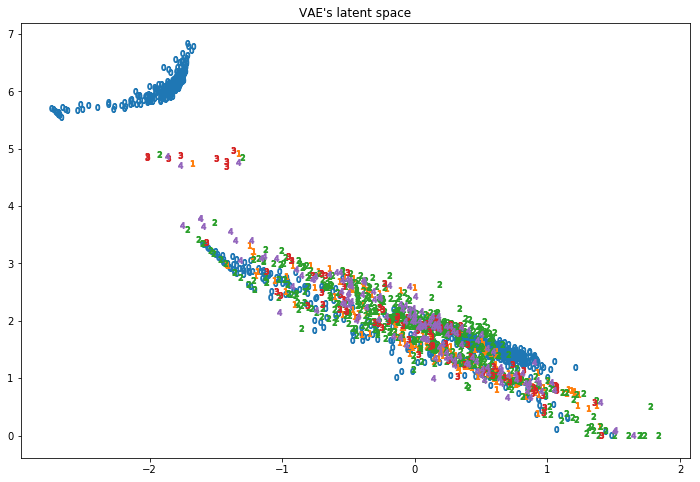

In [24]:
# translate into the latent space
encoder = Model(input_img, z_mu)
X_encoded = encoder.predict(valX, batch_size=batch_size)

# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for i in range(5):
    marker = "$" + str(i) + "$"
    idx = valy == i
    ax.scatter(X_encoded[idx, 0], X_encoded[idx, 1],
              marker=marker, color=cmap(i))
ax.set_title("VAE's latent space")

Again, it seems that it is relatively easy to separate 0 from others but not between 1 - 4.

Text(0.5, 1.0, 'generated images by VAE')

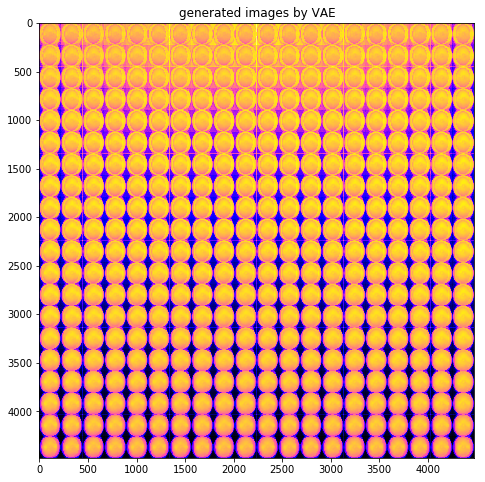

In [25]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = npix
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(figure, cmap='gnuplot2')
ax.set_title('generated images by VAE') 